In [10]:
# Import modules
import numpy as np
from tqdm import tqdm
import pandas as pd
import os


def remover(old_list, to_be_removed):
    if type(to_be_removed) == list:
        new_list = [element for element in old_list if element not in to_be_removed]
    else:
        new_list = [element for element in old_list if element != to_be_removed and type(element) == type(to_be_removed)]
    return new_list



filename = "EventData.csv"
event_data = pd.DataFrame(pd.read_csv(filename, low_memory = False))

datasets = event_data["dataset"]
particles = remover(event_data["particles"], "nan")
data_variables = remover(event_data["data_variables"], "nan")
event_data = event_data.drop(["Unnamed: 0", "dataset", "particles", "data_variables"], axis = 1)
data = np.array([event_data[column] for column in list(event_data.columns.values)])

event_data = pd.DataFrame(data = data.T, columns = pd.MultiIndex.from_tuples(zip(particles, data_variables)))
print(event_data["electron1"].iloc[11])

eta              -1.199
phi              -1.061
PT               95.420
jmass             0.000
ntrk              1.000
btag              0.000
hadem             0.000
ptmax           489.990
stuff_amount      7.000
MET             123.230
Name: 11, dtype: float64


In [3]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


# Data and real values being split
x = event_data
y = datasets
print(x.shape)
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# Define the model and train it
xgb_model = xgb.XGBClassifier(objective = "multi:softprob", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss')
xgb_model = xgb.XGBClassifier(objective = "multi:softprob", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss', max_depth = 3)

# Bruk disse om det er 2 forskjellige type dataset, derfor "binary"
# xgb_model = xgb.XGBClassifier(objective = "binary:logistic", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss')
# xgb_model = xgb.XGBClassifier(objective = "binary:logistic", random_state = 22, use_label_encoder = False, eval_metric = 'mlogloss', max_depth = 3)

(399638, 820)
(399638,)
(319710, 820)
(79928, 820)
(319710,)
(79928,)


In [4]:
# Train model on data
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=22, reg_alpha=0, ...)

In [5]:
# Make predictions with model
y_pred = xgb_model.predict(x_test)

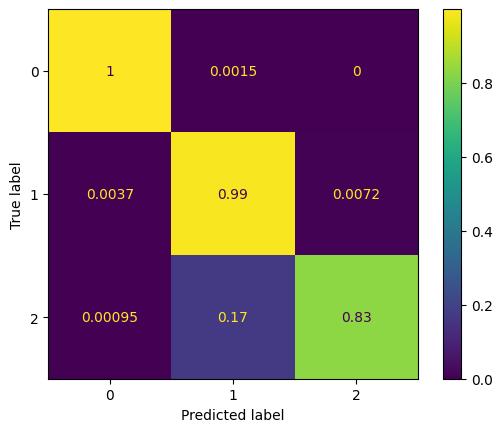

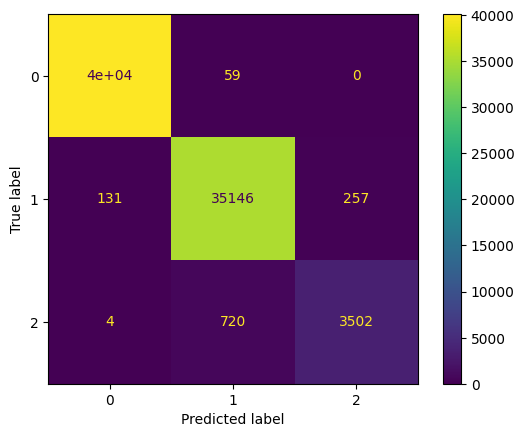

In [6]:
# Plot confusion matrix
conf = confusion_matrix(y_test, y_pred)
disp_norm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix = conf)
disp.plot()
plt.show()

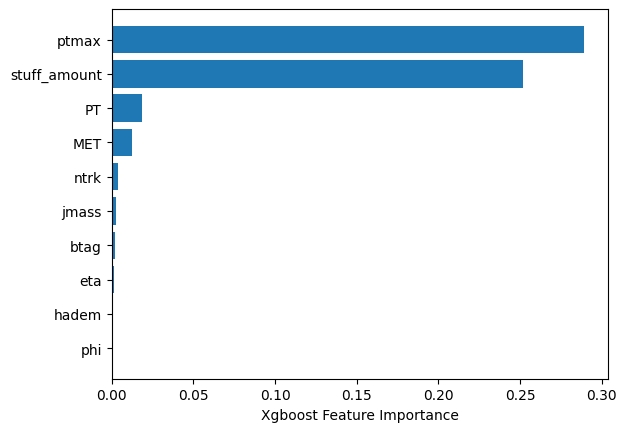

In [7]:
# Plot variables by importance for prediction
def first_el_finder(input_list, el_to_find, index):
    for el in input_list:
        if type(el) != list and type(el) != tuple:
            if el == el_to_find:
                return el
        else:
            if el[index] == el_to_find:
                return el


sorted_idx = xgb_model.feature_importances_.argsort()[::-1]
varidx = list(zip(np.array(data_variables)[sorted_idx], sorted_idx))
vars = [first_el_finder(varidx, data_variable, 0) for data_variable in list(dict.fromkeys(data_variables))]

plot_vars = [var[0] for var in vars]
plot_vals = [xgb_model.feature_importances_[var[1]] for var in vars]

sorted_idx = np.array(plot_vals).argsort()

plt.barh(np.array(plot_vars)[sorted_idx], np.array(plot_vals)[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()